In [1]:
import os
os.chdir("..")

In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import plotting_extent
import numpy as np
import rioxarray as rxr

from SSTImportanceSampling  import Preprocessor

In [98]:
import pathlib
import pandas as pd
import rioxarray as rxr
from rioxarray.exceptions import NoDataInBounds

def atlas14_basin_summary(asc_dir, watershed_gdf, watershed_name):
    """
    Compute mean Atlas 14 precipitation (inches) from ASCII grids for a watershed.

    Parameters
    ----------
    asc_dir : str or pathlib.Path
        Folder containing .asc grids
    watershed_gdf : geopandas.GeoDataFrame
        Watershed polygon(s)
    watershed_name : str
        Name of watershed for labeling

    Returns
    -------
    pd.DataFrame
    """

    def get_precip(asc_path, gdf):
        da = rxr.open_rasterio(asc_path).squeeze()
        # assign CRS if missing
        if da.rio.crs is None:
            for crs in [4269, 4326]:  # NAD83 → WGS84
                try:
                    da_try = da.rio.write_crs(crs)
                    g = gdf.to_crs(da_try.rio.crs)
                    da_clip = da_try.rio.clip(g.geometry, drop=True)
                    da_valid = da_clip.where(da_clip >= 0)
                    return float(da_valid.mean().item() / 1000)
                except NoDataInBounds:
                    continue
            raise RuntimeError(f"No overlap found for {asc_path}")
        else:
            g = gdf.to_crs(da.rio.crs)
            da_clip = da.rio.clip(g.geometry, drop=True)
            da_valid = da_clip.where(da_clip >= 0)
            return float(da_valid.mean().item() / 1000)

    asc_dir = pathlib.Path(asc_dir)
    records = [
        {"file": asc.stem, "avg_precip": get_precip(asc, watershed_gdf)}
        for asc in asc_dir.glob("*.asc")
    ]
    df = pd.DataFrame(records)

    # --- Generic parsing ---
    # Return period (number before 'yr')
    df["Return period"] = (
        df["file"].str.extract(r"(\d+)yr")[0].astype(int)
    )

    # Duration (number before 'da')
    days = df["file"].str.extract(r"yr(\d{1,2})da")[0].astype(int)
    df["Period"] = days.map(lambda d: f"{d*24} hour")

    # Bound: l = lower, u = upper, else mean
    df["bound"] = (
        df["file"].str.extract(r"da([lu])?_ams")[0]
        .map({"l": "lower", "u": "upper"})
        .fillna("mean")
    )

    df["watershed"] = watershed_name

    return df[["watershed", "file", "Return period", "Period", "bound", "avg_precip"]]

In [56]:
def plot_atlas14_bounds(df, watershed_name):
    plt.figure(figsize=(6,4))
    for bound, style in zip(["mean", "lower", "upper"], ["o", "o", "o"]):
        sub = df[df["bound"] == bound]
        plt.plot(sub["Return period"], sub["avg_precip"], style, label=bound, alpha=0.8)

    plt.xscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Average Precipitation (inches)")
    plt.title(f"{watershed_name} - Atlas 14")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

<h3> Trinity </h3>

In [99]:
watershed_name = "Trinity"
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")
asc_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/atlas14/texas"

In [100]:
atlas14 = atlas14_basin_summary(
                    asc_path,
                    watershed.watershed_gdf,
                    watershed_name
)

In [101]:
atlas14.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}/atlas14_noARF.pq")

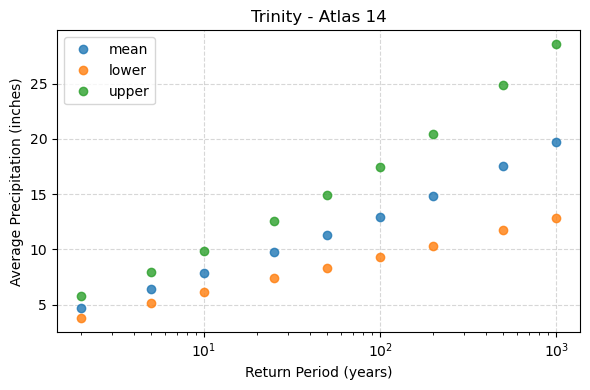

In [102]:
plot_atlas14_bounds(atlas14,watershed_name)

<h3> Kanawha </h3>

In [103]:
watershed_name = "Kanawha"
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")
asc_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/atlas14/orb"

In [104]:
atlas14 = atlas14_basin_summary(
                    asc_path,
                    watershed.watershed_gdf,
                    watershed_name
)

In [105]:
atlas14.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}/atlas14_noARF.pq")

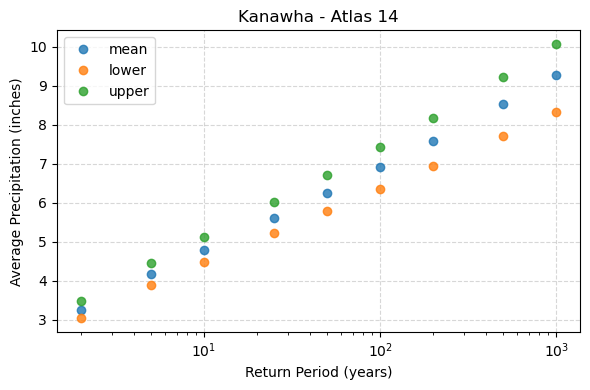

In [106]:
plot_atlas14_bounds(atlas14,watershed_name)

<h3> Denton </h3>

In [110]:
watershed_name = "Denton"
watershed = Preprocessor.load(config_path = f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{watershed_name}/config.json")
asc_path = "/workspaces/Importance-Sampling-for-SST/data/0_source/atlas14/texas"

In [111]:
atlas14 = atlas14_basin_summary(
                    asc_path,
                    watershed.watershed_gdf,
                    watershed_name
)

In [112]:
atlas14.to_parquet(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}/atlas14_noARF.pq")

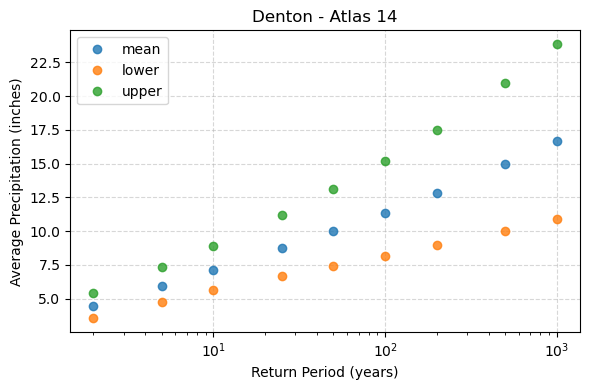

In [113]:
plot_atlas14_bounds(atlas14,watershed_name)